<a href="https://colab.research.google.com/github/CampbellAgreev/Analysis-of-housing-information/blob/master/ResNetAndVGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, Concatenate, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import MeanIoU

#Load a pre-trained encoder
def build_encoder(backbone_name="resnet50", input_shape=(128, 128, 3)):
    if backbone_name.lower() == "resnet50":
        base_model = ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)
    elif backbone_name.lower() == "vgg16":
        base_model = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
    else:
        raise ValueError("Invalid backbone_name. Choose 'resnet50' or 'vgg16'.")

    #encoder layers for skip connections
    skip_layers = [base_model.get_layer(name).output for name in ["conv2_block3_out", "conv3_block4_out", "conv4_block6_out"]] if backbone_name == "resnet50" else [
        base_model.get_layer(name).output for name in ["block2_conv2", "block3_conv3", "block4_conv3"]
    ]

    return Model(inputs=base_model.input, outputs=skip_layers, name=f"{backbone_name}_encoder")

#custom decoder
def build_decoder(skip_outputs, num_classes):
    x = skip_outputs[-1]

    #
    x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding="same")(x)
    x = Concatenate()([x, skip_outputs[-2]])
    x = Conv2D(256, (3, 3), activation="relu", padding="same")(x)

    #
    x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding="same")(x)
    x = Concatenate()([x, skip_outputs[-3]])
    x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)

    #
    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same")(x)
    x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)

    #
    x = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding="same")(x)
    x = Conv2D(32, (3, 3), activation="relu", padding="same")(x)

    #
    x = Conv2D(num_classes, (1, 1), activation="sigmoid")(x)

    return x

#Combining encoder and decoder into a full model
def build_segmentation_model(backbone_name="resnet50", input_shape=(128, 128, 3), num_classes=1):
    encoder = build_encoder(backbone_name, input_shape)
    skip_outputs = encoder.output

    decoder_output = build_decoder(skip_outputs, num_classes)

    model = Model(inputs=encoder.input, outputs=decoder_output, name="segmentation_model")
    return model

#Compile and train the model
def compile_and_train(model, train_dataset, val_dataset, epochs=20):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss="binary_crossentropy",
                  metrics=[MeanIoU(num_classes=2)])

    model.fit(train_dataset,
              validation_data=val_dataset,
              epochs=epochs)

    return model

#####
if __name__ == "__main__":
    #
    input_shape = (128, 128, 3)
    num_classes = 1

    #
    model = build_segmentation_model(backbone_name="resnet50", input_shape=input_shape, num_classes=num_classes)
    model.summary()

    #
    train_dataset = tf.data.Dataset.from_tensor_slices((tf.random.normal((10, 128, 128, 3)), tf.random.uniform((10, 128, 128, 1), maxval=2, dtype=tf.int32))).batch(2)
    val_dataset = tf.data.Dataset.from_tensor_slices((tf.random.normal((5, 128, 128, 3)), tf.random.uniform((5, 128, 128, 1), maxval=2, dtype=tf.int32))).batch(2)

    #
    trained_model = compile_and_train(model, train_dataset, val_dataset, epochs=2)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "segmentation_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 13,594,465 (51.86 MB)

 Trainable params: 13,563,873 (51.74 MB)

 Non-trainable params: 30,592 (119.50 KB)

Epoch 1/2
5/5 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - loss: 0.7108 - mean_io_u: 0.2484 - val_loss: 0.6952 - val_mean_io_u: 0.2493
Epoch 2/2
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.6946 - mean_io_u: 0.2484 - val_loss: 0.6939 - val_mean_io_u: 0.2493


In [2]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, Concatenate, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import MeanIoU

#
def build_encoder(backbone_name="vgg16", input_shape=(128, 128, 3)):
    if backbone_name.lower() == "vgg16":
        base_model = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
    else:
        raise ValueError("Invalid backbone_name. Only 'vgg16' is supported.")

    #encoder layers for skip connections
    skip_layers = [
        base_model.get_layer(name).output for name in ["block2_conv2", "block3_conv3", "block4_conv3"]
    ]

    return Model(inputs=base_model.input, outputs=skip_layers, name=f"{backbone_name}_encoder")

#custom decoder
def build_decoder(skip_outputs, num_classes):
    x = skip_outputs[-1]

    #
    x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding="same")(x)
    x = Concatenate()([x, skip_outputs[-2]])
    x = Conv2D(256, (3, 3), activation="relu", padding="same")(x)

    #
    x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding="same")(x)
    x = Concatenate()([x, skip_outputs[-3]])
    x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)

    #
    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same")(x)
    x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)

    #
    x = Conv2D(num_classes, (1, 1), activation="sigmoid")(x)

    return x

#Combining encoder and decoder into a full model
def build_segmentation_model(backbone_name="vgg16", input_shape=(128, 128, 3), num_classes=1):
    encoder = build_encoder(backbone_name, input_shape)
    skip_outputs = encoder.output

    decoder_output = build_decoder(skip_outputs, num_classes)

    model = Model(inputs=encoder.input, outputs=decoder_output, name="segmentation_model")
    return model

#Compile and train the model
def compile_and_train(model, train_dataset, val_dataset, epochs=20):
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss="binary_crossentropy",
                  metrics=[MeanIoU(num_classes=2)])

    model.fit(train_dataset,
              validation_data=val_dataset,
              epochs=epochs)

    return model

####
if __name__ == "__main__":
    #
    input_shape = (128, 128, 3)
    num_classes = 1

    #
    model = build_segmentation_model(backbone_name="vgg16", input_shape=input_shape, num_classes=num_classes)
    model.summary()

    #
    train_dataset = tf.data.Dataset.from_tensor_slices((tf.random.normal((10, 128, 128, 3)), tf.random.uniform((10, 128, 128, 1), maxval=2, dtype=tf.int32))).batch(2)
    val_dataset = tf.data.Dataset.from_tensor_slices((tf.random.normal((5, 128, 128, 3)), tf.random.uniform((5, 128, 128, 1), maxval=2, dtype=tf.int32))).batch(2)

    #
    trained_model = compile_and_train(model, train_dataset, val_dataset, epochs=2)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "segmentation_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 128, 128,  │      1,792 │ input_layer_1[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 128, 128,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 64, 64,    │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 64, 64,    │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 64, 64,    │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 32, 32,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 32, 32,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 32, 32,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 32, 32,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 16, 16,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 16, 16,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 16, 16,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 16, 16,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 32, 32,    │  1,179,904 │ block4_conv3[0][… │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 512)              │            │ block3_conv3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │  1,179,904 │ concatenate_2[0]

 Total params: 10,695,937 (40.80 MB)

 Trainable params: 10,695,937 (40.80 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/2
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 1.4587 - mean_io_u_1: 0.2507 - val_loss: 0.9976 - val_mean_io_u_1: 0.2495
Epoch 2/2
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - loss: 0.9722 - mean_io_u_1: 0.2507 - val_loss: 0.8862 - val_mean_io_u_1: 0.2495


In [3]:
from tensorflow.keras.layers import UpSampling2D, Conv2D, Concatenate

def build_decoder(skip_outputs, num_classes, input_shape):
    x = skip_outputs[0]

    for i in range(1, len(skip_outputs)):

        x = UpSampling2D(size=(2, 2))(x)


        x = Concatenate()([x, skip_outputs[i]])


        x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
        x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)


    decoder_output = Conv2D(num_classes, (1, 1), activation="softmax", padding="same")(x)

    return decoder_output


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


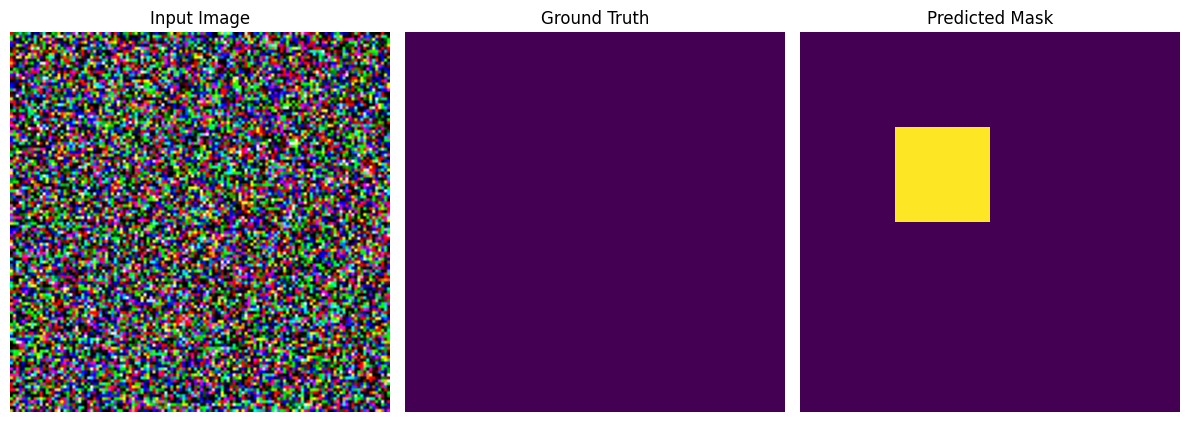

In [4]:
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.applications import ResNet50

resnet_model = ResNet50(weights='imagenet', include_top=False)

#data from the validation set
images, true_masks = next(iter(val_dataset))

#predictions
predicted_masks = resnet_model.predict(images)

# Visualization
fig, ax = plt.subplots(1, 3, figsize=(12, 8))

#
ax[0].imshow(images[0])
ax[0].set_title("Input Image")
ax[0].axis('off')

ax[1].imshow(np.argmax(true_masks[0], axis=-1))
ax[1].set_title("Ground Truth")
ax[1].axis('off')

ax[2].imshow(np.argmax(predicted_masks[0], axis=-1))
ax[2].set_title("Predicted Mask")
ax[2].axis('off')

plt.tight_layout()
plt.show()